In [1]:
!pip install pandas
!pip install numpy==1.23.5
!pip install tensorflow
!pip install imblearn
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install graphviz
!pip install shap
!pip install numpy
!pip install --upgrade xlrd
!pip install lightgbm
!pip install catboost
!pip install seaborn
!pip install tabpfn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [55]:
import pandas as pd
import numpy as  np
import tensorflow as tf
from tensorflow.python.client import device_lib

from imblearn.under_sampling import RandomUnderSampler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler


import seaborn as sns

import matplotlib.pyplot as plt


import shap

import torch
from tabpfn import TabPFNClassifier


Lendo o dataset e substituindo as colunas não numericas como sexo e exames de positovo e negativo, por valores numericos

In [3]:
df = pd.read_excel("DBCleanPlusCompleted.xlsx")

string_to_number = preprocessing.LabelEncoder()
for i in df.columns:
    if df[i].dtype == object:
        df[i] = string_to_number.fit_transform(df[i])



NameError: name 'pd' is not defined

In [4]:
X = df.drop(['Desfecho'], axis = 1)
y = df['Desfecho']

rus = RandomUnderSampler(sampling_strategy=1, random_state = 24)
X_res, y_res = rus.fit_resample(X,y)
X_res = X_res.drop(columns=['Código'])

for col in X_res.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns:
    X_res[col] = (X_res[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

scaler = MinMaxScaler()       #since knnimputer is distance based, we should normalize before imputing to avoid bias
X_res = pd.DataFrame(scaler.fit_transform(X_res), columns = X_res.columns)

imputer = KNNImputer(n_neighbors=8, weights="uniform")
X_res = pd.DataFrame(imputer.fit_transform(X_res), columns = X_res.columns)
#Split data into 70% for training and 30% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X_res, y_res, test_size=0.3, random_state = 24)

contagem_desfecho = y_res.value_counts()
print(contagem_desfecho)

Desfecho
0    261
1    261
Name: count, dtype: int64


XGBoost

XGBoost 
 Accuracy Score:  0.6878980891719745 
 Precision:  0.6933333333333334 
 Recall:  0.6666666666666666 
 F1 :  0.6797385620915033
 Sensitivity:  0.7088607594936709 
 Specificity:  0.6666666666666666


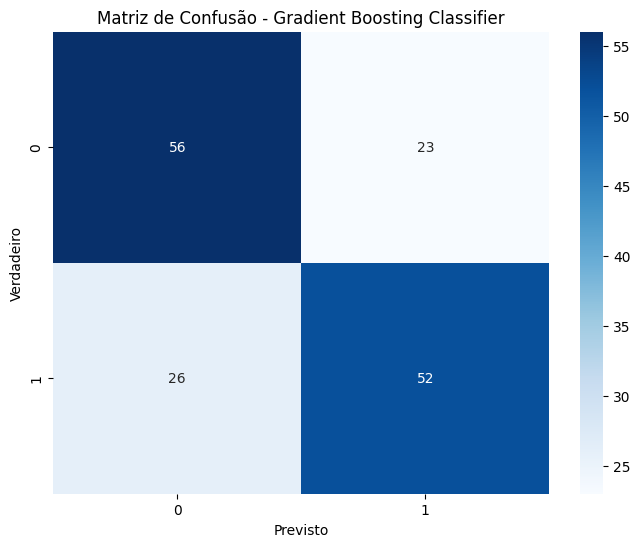

              precision    recall  f1-score   support

           0       0.68      0.71      0.70        79
           1       0.69      0.67      0.68        78

    accuracy                           0.69       157
   macro avg       0.69      0.69      0.69       157
weighted avg       0.69      0.69      0.69       157



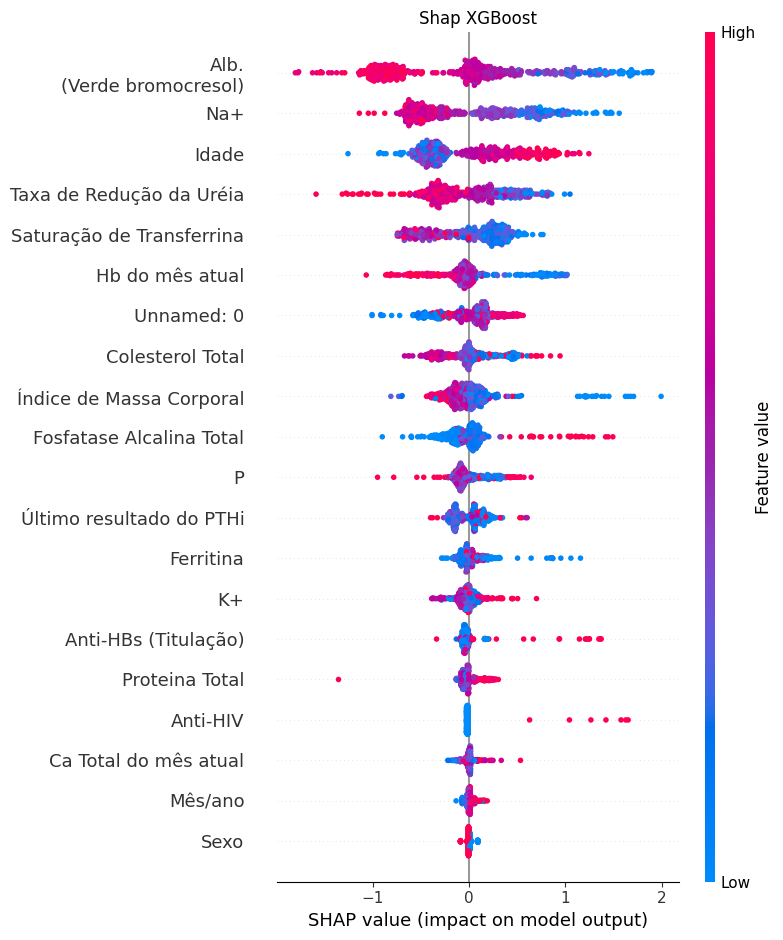

In [63]:
# Treinar o modelo de Gradient Boosting
xgb = GradientBoostingClassifier()
xgb.fit(X_train, Y_train)
predictions = xgb.predict(X_test)

# Calcular métricas de desempenho
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

print("XGBoost \n Accuracy Score: ", accuracy, "\n Precision: ", precision, "\n Recall: ", recall, "\n F1 : ", f1)

# Calcular matriz de confusão
cm_xgb = confusion_matrix(Y_test, predictions)
sensitivity = cm_xgb[0,0]/(cm_xgb[0,0]+cm_xgb[0,1])
specificity = cm_xgb[1,1]/(cm_xgb[1,0]+cm_xgb[1,1])

print(" Sensitivity: ", sensitivity,"\n Specificity: ", specificity)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Gradient Boosting Classifier')
plt.show()

print(classification_report(Y_test, predictions))

# Explicação com SHAP
X_frame = pd.DataFrame(data=X_res)

plt.title('Shap XGBoost')
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_frame)
shap.summary_plot(shap_values_xgb, X_res)

# Corrigir a chamada para shap.force_plot
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0], X_res.iloc[0])

Random Forest

Random Forest Classifier 
 Accuracy Score:  0.7070063694267515 
 Precision:  0.7285714285714285 
 Recall:  0.6538461538461539 
 F1 :  0.6891891891891891
 Sensitivity:  0.759493670886076 
 Specificity:  0.6538461538461539


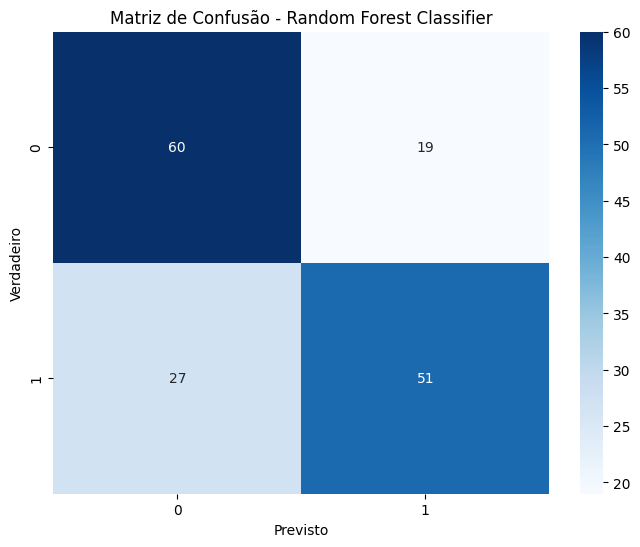

              precision    recall  f1-score   support

           0       0.69      0.76      0.72        79
           1       0.73      0.65      0.69        78

    accuracy                           0.71       157
   macro avg       0.71      0.71      0.71       157
weighted avg       0.71      0.71      0.71       157



PermutationExplainer explainer: 523it [02:19,  3.48it/s]                         


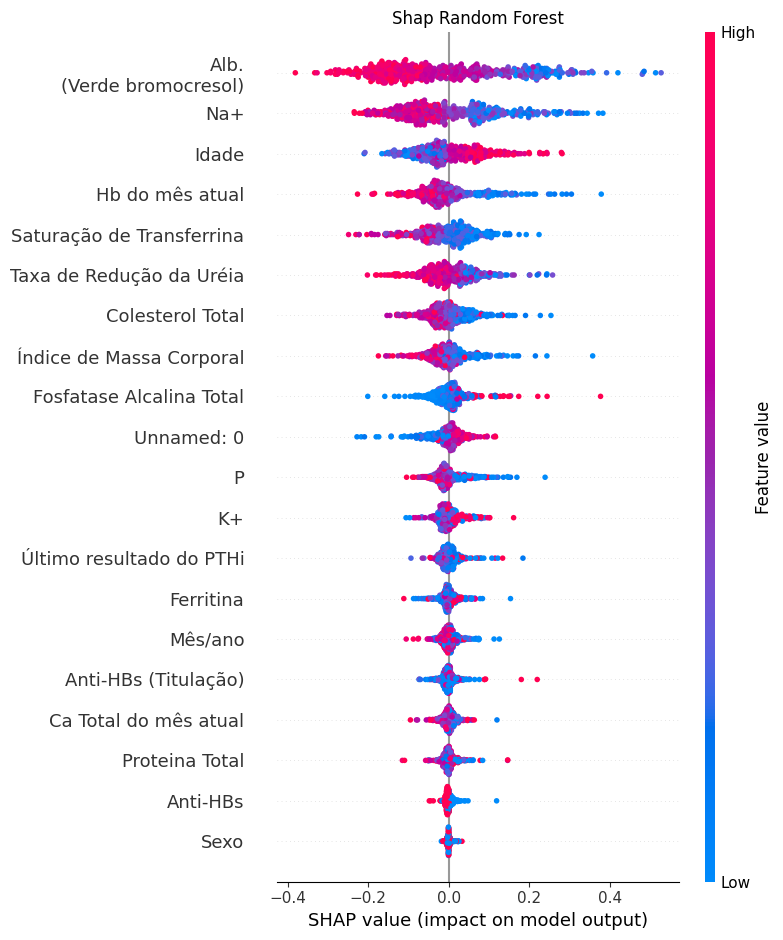

In [73]:
rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(X_train, Y_train)

predictions = rfc.predict(X_test)
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

print("Random Forest Classifier \n Accuracy Score: ", accuracy, "\n Precision: ", precision, "\n Recall: ", recall, "\n F1 : ", f1)

cm_rfc = confusion_matrix(Y_test, predictions)
sensitivity = cm_rfc[0,0]/(cm_rfc[0,0]+cm_rfc[0,1])

specificity = cm_rfc[1,1]/(cm_rfc[1,0]+cm_rfc[1,1])

print(" Sensitivity: ", sensitivity,"\n Specificity: ", specificity)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfc, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Random Forest Classifier')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()


print(classification_report(Y_test, predictions))

X_frame = pd.DataFrame(data=X_res)

plt.title('Shap Random Forest')
explainer_rfc = shap.Explainer(rfc.predict, X_frame)
shap_values_rfc = explainer_rfc(X_frame)
shap.summary_plot(shap_values_rfc, X_res)

Logistic Regression

Logistic Regression 
 Accuracy Score:  0.7261146496815286 
 Precision:  0.7611940298507462 
 Recall:  0.6538461538461539 
 F1 :  0.7034482758620689
 Sensitivity:  0.7974683544303798 
 Specificity:  0.6538461538461539


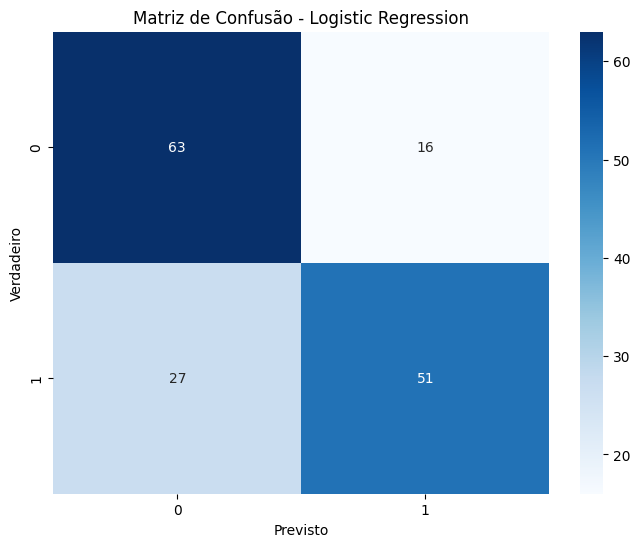

              precision    recall  f1-score   support

           0       0.70      0.80      0.75        79
           1       0.76      0.65      0.70        78

    accuracy                           0.73       157
   macro avg       0.73      0.73      0.72       157
weighted avg       0.73      0.73      0.72       157



PermutationExplainer explainer: 523it [00:10,  2.92it/s]                         


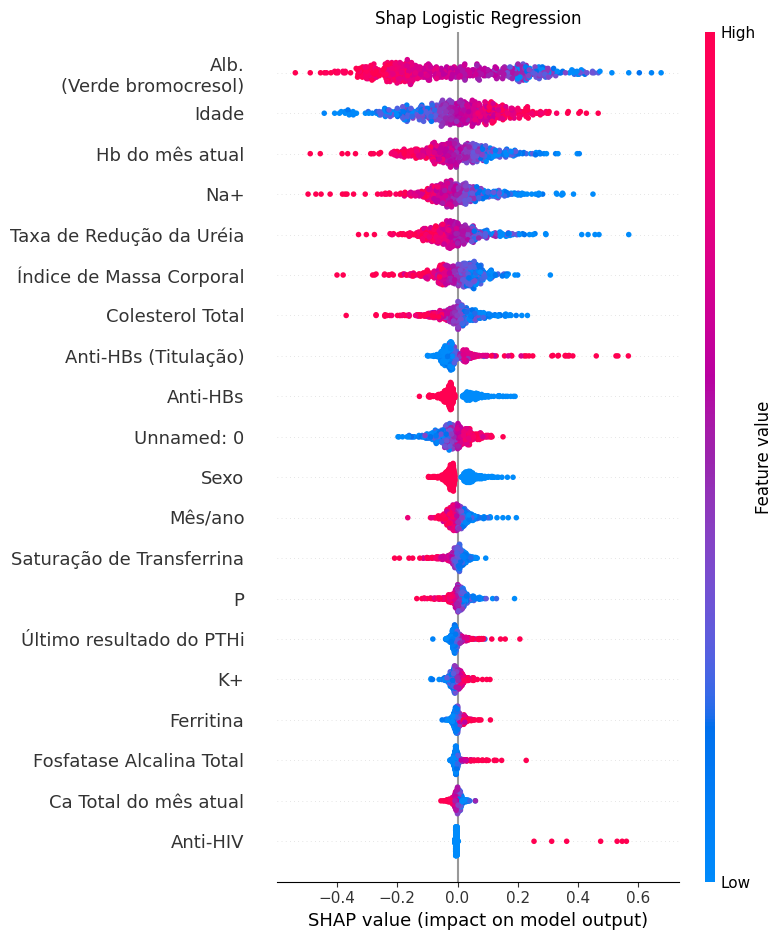

In [68]:
lr = LogisticRegression()

lr.fit(X_train, Y_train)
y_pred = lr.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print("Logistic Regression \n Accuracy Score: ", accuracy, "\n Precision: ", precision, "\n Recall: ", recall, "\n F1 : ", f1)

cm_lr = confusion_matrix(Y_test, y_pred)
sensitivity = cm_lr[0,0]/(cm_lr[0,0]+cm_lr[0,1])
specificity = cm_lr[1,1]/(cm_lr[1,0]+cm_lr[1,1])

print(" Sensitivity: ", sensitivity,"\n Specificity: ", specificity)


plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Logistic Regression')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

print(classification_report(Y_test, y_pred))

X_frame = pd.DataFrame(data=X_res)

plt.title('Shap Logistic Regression')
explainer_lr = shap.Explainer(lr.predict, X_frame)
shap_values_lr = explainer_lr(X_frame)
shap.summary_plot(shap_values_lr, X_res)


TabPFN

C:\Users\vhlab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TabPFN 
 Accuracy Score:  0.6878980891719745 
 Precision:  0.7101449275362319 
 Recall:  0.6282051282051282 
 F1 :  0.6666666666666666
 Sensitivity:  0.7468354430379747 
 Specificity:  0.6282051282051282


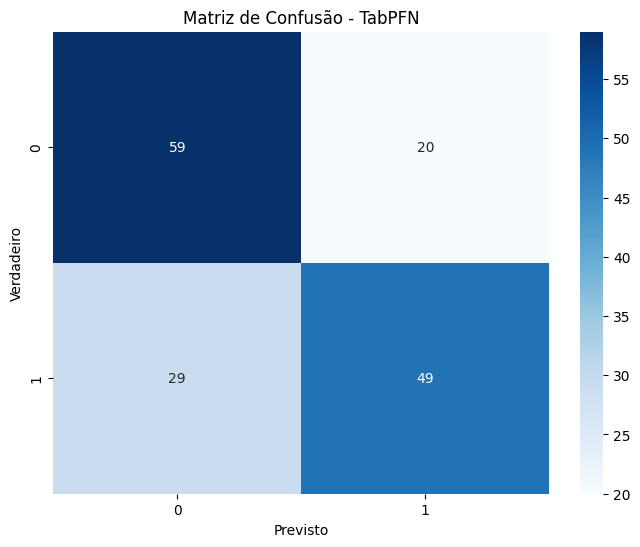

              precision    recall  f1-score   support

           0       0.67      0.75      0.71        79
           1       0.71      0.63      0.67        78

    accuracy                           0.69       157
   macro avg       0.69      0.69      0.69       157
weighted avg       0.69      0.69      0.69       157



In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = TabPFNClassifier(device=device)

model.fit(X_train,Y_train)
predictions = model.predict(X_test)

accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

print("TabPFN \n Accuracy Score: ", accuracy, "\n Precision: ", precision, "\n Recall: ", recall, "\n F1 : ", f1)

cm = confusion_matrix(Y_test, predictions)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
specificity = cm[1,1]/(cm[1,0]+cm[1,1])

print(" Sensitivity: ", sensitivity,"\n Specificity: ", specificity)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - TabPFN')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

print(classification_report(Y_test, predictions))
